In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import keras
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.applications.vgg19 import VGG19,preprocess_input,decode_predictions

In [2]:
# Define the data augmentation parameters
train_datagen=ImageDataGenerator(zoom_range=0.5,shear_range=0.3,horizontal_flip=True,preprocessing_function=preprocess_input)
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

# Load the training and validation data
train=train_datagen.flow_from_directory(directory="C:/Users/AVIGHYAT/Downloads/dermno/train",target_size=(256,256),batch_size=32)
val=val_datagen.flow_from_directory(directory="C:/Users/AVIGHYAT/Downloads/dermno/val",target_size=(256,256),batch_size=32)

Found 697 images belonging to 9 classes.
Found 181 images belonging to 9 classes.


In [3]:
# Get a sample of the training data
t_img,label=train.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


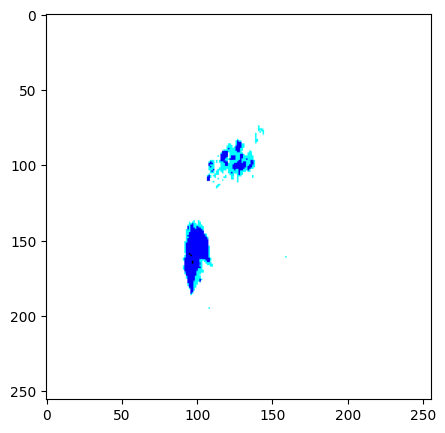

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


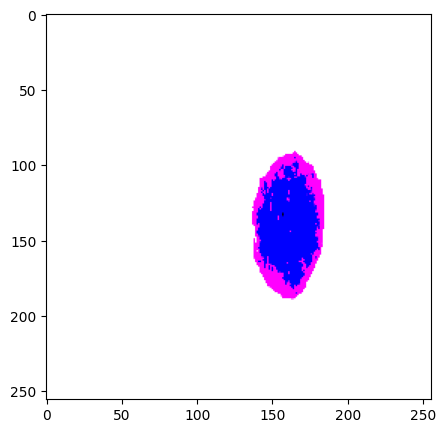

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


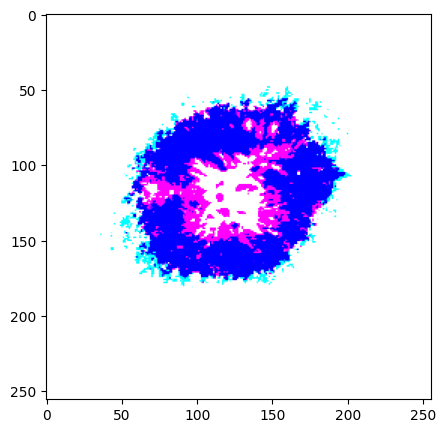

In [4]:
# Plot the sample images
def plotImage(img_arr,label):
  for im,l in zip(img_arr,label):
    plt.figure(figsize=(5,5))
    plt.imshow(im)
    plt.show()

plotImage(t_img[:3],label[:3])

In [5]:
from keras.layers import Dense,Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
import keras

# Load the pre-trained VGG19 model
base_model=VGG19(input_shape=(256,256,3),weights='imagenet',include_top=False)

In [6]:
# Freeze the weights of the pre-trained model
for layer in base_model.layers:
  layer.trainable=False

In [7]:
# Add a new classification head to the model
X=Flatten(name='flatten')(base_model.output)
X=Dense(units=9,activation='softmax',name='fc1')(X)

# Create the model
model=Model(base_model.input,X)

In [8]:
# Compile the model
model.compile(optimizer='adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [9]:
# Define the callbacks
from keras.callbacks import ModelCheckpoint,EarlyStopping
es=EarlyStopping(monitor='val_accuracy',min_delta=0.01,patience=3,verbose=1)
mc=ModelCheckpoint(filepath="dermenaop_model.h5",monitor='val_accuracy',min_delta=0.01,patience=3,verbose=1,save_best_only= True)
cb=[es,mc]

In [10]:
# Train the model
his=model.fit_generator(train,steps_per_epoch=20,epochs=30,verbose=1,callbacks=cb,validation_data=val,validation_steps=16)

C:\Users\AVIGHYAT\AppData\Local\Temp\ipykernel_34424\30562431.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  his=model.fit_generator(train,steps_per_epoch=20,epochs=30,verbose=1,callbacks=cb,validation_data=val,validation_steps=16)


Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 11.8322 - accuracy: 0.3523WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 16 batches). You may need to use the repeat() function when building your dataset.

Epoch 1: val_accuracy improved from -inf to 0.58564, saving model to dermenaop_model.h5
20/20 [==============================] - 106s 5s/step - loss: 11.8322 - accuracy: 0.3523 - val_loss: 6.5194 - val_accuracy: 0.5856
Epoch 2/30


C:\Users\AVIGHYAT\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 77s 4s/step - loss: 5.3477 - accuracy: 0.6540
Epoch 3/30
20/20 [==============================] - 77s 4s/step - loss: 3.5394 - accuracy: 0.7563
Epoch 4/30
20/20 [==============================] - 76s 4s/step - loss: 2.9612 - accuracy: 0.7441
Epoch 5/30
20/20 [==============================] - 77s 4s/step - loss: 3.3535 - accuracy: 0.7520
Epoch 6/30
20/20 [==============================] - 81s 4s/step - loss: 3.4279 - accuracy: 0.7804
Epoch 7/30
20/20 [==============================] - 78s 4s/step - loss: 2.3373 - accuracy: 0.8167
Epoch 8/30
20/20 [==============================] - 77s 4s/step - loss: 2.8050 - accuracy: 0.8199
Epoch 9/30
20/20 [==============================] - 76s 4s/step - loss: 2.6475 - accuracy: 0.8104
Epoch 10/30
20/20 [==============================] - 82s 4s/step - loss: 2.1001 - accuracy: 0.8578
Epoch 11/30
20/20 [==============================] - 81s 4s/step - loss: 1.6146 - accuracy: 0.8594
Epoch 12/30
20/20 [==========

In [11]:
# Evaluate the model on the validation set
acc=model.evaluate_generator(val)[1]
print(f"the accuracy of your model is {acc*100}%")

C:\Users\AVIGHYAT\AppData\Local\Temp\ipykernel_34424\1693740532.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc=model.evaluate_generator(val)[1]


the accuracy of your model is 75.13812184333801%


In [12]:
# Save the model
model.save("dermena_model.h5")

In [17]:
# Load the reference dictionary
ref=dict(zip(list(train.class_indices.values()),list(train.class_indices.keys())))

In [30]:
# Define a function to make predictions
def prediction(image_path):
     img=load_img(image_path,target_size=(256,256))
     i=img_to_array(img)
     im=preprocess_input(i)
     img=np.expand_dims(im,axis=0)
     pred=np.argmax(model.predict(img))
     print(f"the image belongs to {ref[pred]}")
     plt.imshow(i.astype(int))
     plt.axis('off')
     plt.show()

Enter the image path: "C:\Users\AVIGHYAT\OneDrive\Desktop\begin.jpeg"
1/1 [==============================] - 0s 150ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


the image belongs to Benign keratosis


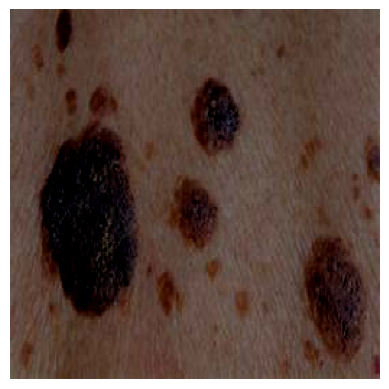

In [34]:
image_path = input("Enter the image path: ")
image_path = image_path.strip('"')
prediction(image_path)